# Education in Denmark 2008-2019

The scope of this project is to examine the development of the level of education in Denmark using data from Denmark Statistisk. First, we examine the overall development of education in Denmark with data on highest education completed. Second, we examine this development by ancestry and, finally by gender. 

Imports and set magics:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets #install with pip install ipywidgets
import numpy as np
from matplotlib import cm

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
import dataproject

# Import pydst
import pydst
dst = pydst.Dst(lang='en')

# 1. Read and clean data

We read the highest completed education data from dst and clean it:

In [2]:
educ_vars = dst.get_variables(table_id='HFUDD10')
educ_vars

# Download data
educ = dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['TOT','H10','H20','H30', 'H40','H50','H60','H70'], 'KØN':['*']})

# Drop columns
drop_these = ['BOPOMR','ALDER']
educ.drop(drop_these, axis=1, inplace=True)

# Rename columns
educ.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year', 'HFUDD':'HCEDUC', 'INDHOLD':'Units'}, inplace=True)

# Set index to year
educ['HCEDUC']=educ.HCEDUC.astype(str).str[4:]
educ.set_index('Year')
educ.head()

,Year,Ancestry,HCEDUC,Gender,Units
0,2006,Descendant,Primary education,Women,8201
1,2006,Descendant,Primary education,Men,9614
2,2006,Descendant,Primary education,Total,17815
3,2006,Descendant,Upper secondary education,Women,2485
4,2006,Descendant,Upper secondary education,Men,2001


# Merge with population data set

## Clean the population data set

We want to compare the level of education by ancestry. Therefor, we have to take into account that the numbers of people within each ancestry are uneven. Thus, we merge with population data by ancestry in order to calculate the share of individuals with completed education by ancestry relative to the number of individuals within ancestries.


In [3]:
# Download population data from dst
pop = dst.get_data(table_id = 'FOLK1C', variables={'Tid':['*'], 'HERKOMST':['*'], 'KØN':['*']})

# Drop columns
drop_these = drop_these = ['OMRÅDE','ALDER', 'IELAND']
pop.drop(drop_these, axis=1, inplace=True)

# Rename columns
pop.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year','INDHOLD':'Pop'}, inplace=True)

for val in ['Q2','Q3','Q4']: 
    I = pop.Year.str.contains(val)
    pop.drop(pop[I].index, inplace=True)

pop.Year.astype(str)
pop['Year']= pop.Year.astype(str).str[:4]


## Merge the datasets

We see that the two datasets do not cover the same years. We want to be able to calculate shares for all observations included our analysis, so we merge the data using the inner method. Thus, we will be left with data for 2008 - 2019.

In [4]:
print(f'Years in education data = {educ.Year.unique()}')
print(f'Years in education data = {pop.Year.unique()}')

Years in education data = [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
Years in education data = ['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020']


In [5]:
# Merge population data with data of highest education completed 
pop.Year = pop.Year.astype(int)
merged = pd.merge(educ, pop, how='inner',on=['Year','Ancestry','Gender'])
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop
0,2008,Descendant,Primary education,Women,9995,58393
1,2008,Descendant,Upper secondary education,Women,3159,58393
2,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393
3,2008,Descendant,Short cycle higher education,Women,395,58393
4,2008,Descendant,Vocational bachelors educations,Women,1048,58393
5,2008,Descendant,Bachelors programmes,Women,397,58393
6,2008,Descendant,Masters programmes,Women,610,58393
7,2008,Descendant,l,Women,19010,58393
8,2008,Descendant,Primary education,Men,11987,60904
9,2008,Descendant,Upper secondary education,Men,2454,60904


## Calculate shares

In [6]:
# Make a new column with calculated shares
merged['Share'] = merged['Units']/merged['Pop'] * 100
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
0,2008,Descendant,Primary education,Women,9995,58393,17.116778
1,2008,Descendant,Upper secondary education,Women,3159,58393,5.409895
2,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393,3.892590
3,2008,Descendant,Short cycle higher education,Women,395,58393,0.676451
4,2008,Descendant,Vocational bachelors educations,Women,1048,58393,1.794736
5,2008,Descendant,Bachelors programmes,Women,397,58393,0.679876
6,2008,Descendant,Masters programmes,Women,610,58393,1.044646
7,2008,Descendant,l,Women,19010,58393,32.555272
8,2008,Descendant,Primary education,Men,11987,60904,19.681794
9,2008,Descendant,Upper secondary education,Men,2454,60904,4.029292


# Graphical analysis

## Education level in Denmark 2008-2019

In order to get an overview of the development in the highest completed education of the population, we make a stacked bar plot of the share of people having each education as the highest they have completed.

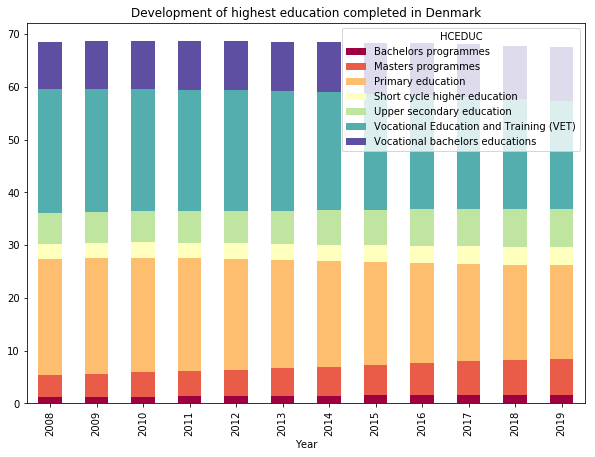

In [17]:
merged1 = merged.copy()

for val in ['Men', 'Women']: 
    I = merged1.Gender.str.contains(val)
    merged1 = merged1.loc[I == False] # keep everything else

for val in ['Descendant','Immigrants','Persons of Danish origin']: 
    J = merged1.Ancestry.str.contains(val)
    merged1 = merged1.loc[J == False] 

pivot = merged1.pivot(index='Year', columns='HCEDUC', values='Share')
pivot.head()
pivot.drop('l',axis=1,inplace=True)
pivot.plot.bar(stacked=True, figsize=(10,7), title='Development of highest education completed in Denmark',colormap='Spectral')


## Education level by ancestry 2008-2019

We wish to get an overview the development in the different education levels by ancestry. 


We wish to normalize the first observation within each ancestry within each education. This makes the comparison of development between ancestries more straight forward. We use the split-apply-combine method to make a column containing the first observation within each ancestry within each education, so we can normalize the data.

Last, we construct a plot with a dropdown menu for choosing the education of interest.

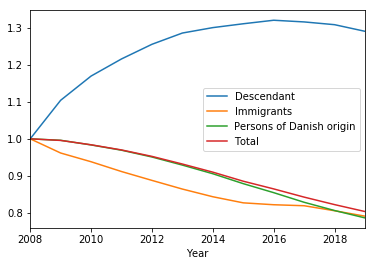

In [19]:
merged.set_index('Year')
merged2 = merged.copy()

# Drop gender from the dataset
for val in ['Men', 'Women']: 
    I = merged2.Gender.str.contains(val)
    merged2 = merged2.loc[I == False] # keep everything else

# a. Split the dataset
merged_grouped = merged2.groupby(['Ancestry', 'HCEDUC'])
merged_grouped_first = merged_grouped.Share.first()
merged_grouped_first.name = 'first'

# b. Apply 
merged2.set_index(['Ancestry','HCEDUC','Year'],inplace=True)
merged2 = merged2.join(merged_grouped_first,how='left',on=['Ancestry','HCEDUC'])
merged2.reset_index(inplace=True)

# c. combine
merged2['indexed'] = merged2['Share']/merged2['first']

# plot
def plot_index(dataframe, Educations):
    dataframe_indexed = dataframe.set_index(['Year'])
    I = dataframe_indexed.HCEDUC == Educations
    dataframe_indexed[I].groupby(['Ancestry'])['indexed'].plot(legend=True);
    
def plot_index_i(dataframe):
    widgets.interact(plot_index, dataframe = widgets.fixed(dataframe), 
    Educations=widgets.Dropdown(decription='Education', options=dataframe.HCEDUC.unique())
); 
    
#plot_index_i(educ1)
plot_index_i(merged2)

We see that the development in upper secondary education varies a lot by ancestry. We see that the share of immigrants with upper secondary education as their highest completed education is decreasing, the share of descendants with upper secondary education as their higest completed education is increasing and that the development for persons of Danish Origin is more or less the same for the whole period. We would like to explore this further.

## Education share by gender

In [98]:
#Only select the number of people with completed master programmes
for val in ['Upper secondary education']: 
    I = merged.HCEDUC.str.contains(val)
    merged = merged.loc[I == True] # keep everything else
merged.head()

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
0,2008,Descendant,Upper secondary education,Women,3159,58393,5.409895
7,2008,Descendant,Upper secondary education,Men,2454,60904,4.029292
14,2008,Descendant,Upper secondary education,Total,5613,119297,4.705064
21,2008,Immigrants,Upper secondary education,Women,18654,192713,9.679679
28,2008,Immigrants,Upper secondary education,Men,16603,185952,8.928648


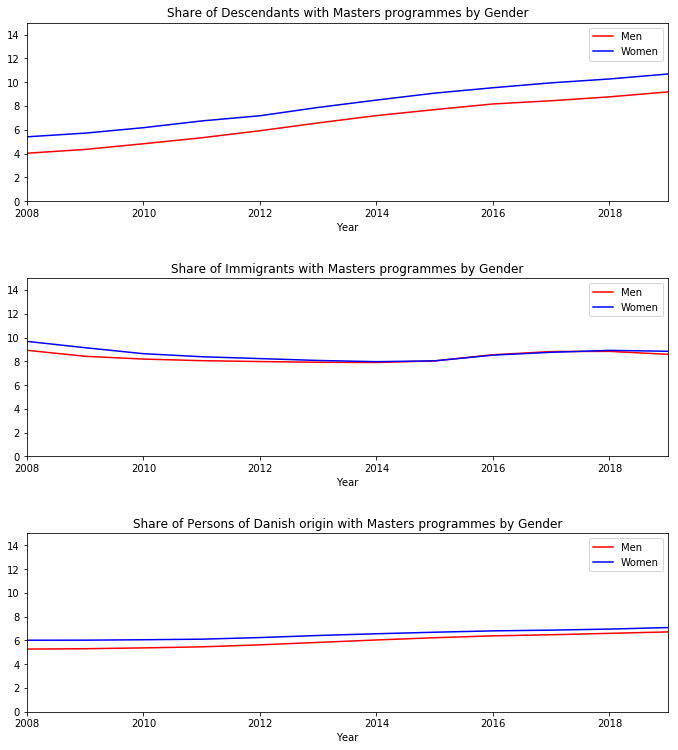

In [99]:
# Make a figure with 3 subplots showing the share of people with master programmes by ancestry and gender
plt.figure(figsize=(12,13))

#Figure 1: Plot with share of descendants with master programmes by gender
merged1 = merged.copy()
I = merged1.Ancestry == 'Descendant'
x = merged[I]

ax = plt.subplot(311)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='red', ax=ax)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='blue', ax=ax)
ax.set_title('Share of Descendants with Masters programmes by Gender')

#Figure 2: Plot with share of immigrants with master programmes by gender
merged2 = merged.copy()
I = merged2.Ancestry == 'Immigrants'
x = merged2[I]

ax1 = plt.subplot(312)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='red', label='Men', ax=ax1)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='blue', ax=ax1, label='Women')
ax1.set_title('Share of Immigrants with Masters programmes by Gender')

#Figure 3: Plot with share of persons of danish origin with master programmes by gender
merged3 = merged.copy()
I = merged3.Ancestry == 'Persons of Danish origin'
x = merged3[I]

ax2 = plt.subplot(313)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='red', ax=ax2)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='blue', ax=ax2)
ax2.set_title('Share of Persons of Danish origin with Masters programmes by Gender')


plt.tight_layout(pad=10,h_pad=3,w_pad=20)

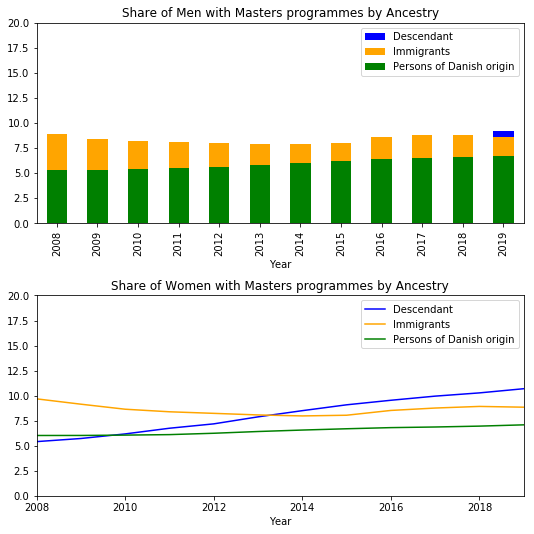

In [102]:
# Make a figure with 3 subplots showing the share of people with master programmes by ancestry and gender
plt.figure(figsize=(10,10))

#Figure 1: Plot with share of men with master programmes by ancestry
merged4 = merged.copy()
I = merged4.Gender == 'Men'
x = merged[I]

ax = plt.subplot(211)

J = x.Ancestry == 'Descendant'
y1 = x[J]
y1.rename(columns = {'Share':'Descendant'}, inplace=True)
y1.plot(kind='bar',stacked=True, x = 'Year', y='Descendant', ylim=(0,20), color='blue', ax=ax)

K = x.Ancestry == 'Immigrants'
y2 = x[K]
y2.rename(columns = {'Share':'Immigrants'}, inplace=True)
y2.plot(kind='bar',stacked=True, x = 'Year', y='Immigrants', ylim=(0,20), color='orange', ax=ax)

K = x.Ancestry == 'Persons of Danish origin'
y2 = x[K]
y2.rename(columns = {'Share':'Persons of Danish origin'}, inplace=True)
y2.plot(kind='bar',stacked=True, x = 'Year', y='Persons of Danish origin', ylim=(0,20), color='green', ax=ax)
ax.set_title('Share of Men with Masters programmes by Ancestry')

#Figure 2: Plot with share of women with master programmes by ancestry
merged5 = merged.copy()
I = merged5.Gender == 'Women'
x = merged[I]

ax1 = plt.subplot(212)

J = x.Ancestry == 'Descendant'
y1 = x[J]
y1.rename(columns = {'Share':'Descendant'}, inplace=True)
y1.plot(kind = 'line', x = 'Year', y='Descendant', ylim=(0,20), color='blue', ax=ax1)

K = x.Ancestry == 'Immigrants'
y2 = x[K]
y2.rename(columns = {'Share':'Immigrants'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Immigrants', ylim=(0,20), color='orange', ax=ax1)

L = x.Ancestry == 'Persons of Danish origin'
y3 = x[L]
y3.rename(columns = {'Share':'Persons of Danish origin'}, inplace=True)
y3.plot(kind='line', x = 'Year', y='Persons of Danish origin', ylim=(0,20), color='green', ax=ax1)
ax1.set_title('Share of Women with Masters programmes by Ancestry')


plt.tight_layout(pad=10,h_pad=1,w_pad=10)

ADD CONCISE CONLUSION.